In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
def classify1(features, MX=5):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        print(BIC[i])
        if BIC[i] < lowest_bic:
            lowest_bic = BIC[i]
            best_gmm = gmm

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type='full', random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

def classify2(features, MX, MN=1):
    parameters = {
        'n_components' : np.arange(MN, MX + 1)
    }
    clf = GridSearchCV(GaussianMixture(covariance_type='full', random_state=0), parameters, cv=5, n_jobs=-1)
    clf.fit(features)
    print("n_components", clf.best_estimator_.n_components)
    return clf.best_estimator_

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [3]:
df = pd.read_csv("data.csv")
df.drop(df.columns[0], inplace=True, axis=1)
scaler = MinMaxScaler()
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])
display(df2.describe())
display(df2.head(5))

,x,y,w,h,Rf,mx,my
count,186008.000000,186008.000000,186008.000000,186008.000000,186008,186008.000000,186008.000000
mean,0.785610,0.415356,0.217875,0.298029,0,0.485989,0.447573
std,0.189616,0.148260,0.104322,0.185771,0,0.025786,0.015789
min,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
25%,0.692058,0.306723,0.151079,0.162791,0,0.486111,0.447368
50%,0.829822,0.376050,0.194245,0.209302,0,0.486111,0.447368
75%,0.925446,0.487395,0.266187,0.403101,0,0.486111,0.447368
max,1.000000,1.000000,1.000000,1.000000,0,1.000000,1.000000


,x,y,w,h,Rf,mx,my
0,0.669368,0.153361,0.244604,0.496124,0,0.486111,0.447368
1,0.816856,0.289916,0.366906,0.333333,0,0.486111,0.447368
2,0.669368,0.153361,0.244604,0.496124,0,0.486111,0.447368
3,0.816856,0.289916,0.366906,0.333333,0,0.486111,0.447368
4,0.669368,0.153361,0.244604,0.496124,0,0.486111,0.447368


In [4]:
bgmm = classify2(df2, 12)

n_components 12


In [5]:
def extend_set(df):
    df_tmp = df[["time", "frame"]].groupby(['time', 'frame']).agg('count')
    df_tmp.reset_index(inplace=True)

    first_time = df_tmp.iloc[0]["time"] 
    first_frame = df_tmp.iloc[0]["frame"]

    last_time = df_tmp.iloc[len(df_tmp) - 1]["time"]
    last_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"]

    dt_time = df_tmp.iloc[len(df_tmp) - 1]["time"] - df_tmp.iloc[len(df_tmp) - 2]["time"]
    dt_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"] - df_tmp.iloc[len(df_tmp) - 2]["frame"]

    df_app = df.apply(lambda x: [x['time'] - first_time + last_time + dt_time, x['frame'] - first_frame + last_frame + dt_frame] + list(x[2:]), axis=1)
    df_app = df.append(df_app)
    df_app.reset_index(inplace=True, drop=True)
    return df_app
#df = extend_set(df)
#df = extend_set(df)
#df = extend_set(df)

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

#display(df3.head(11))

#df3 = df3.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)
#df3_test = df3_test.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)

display(df3.head(11))

#arr = df3_test.drop(["frame", "time"], axis=1)
#display(np.array(arr))
#display(np.array(arr) / np.linalg.norm(arr, axis=1))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

#seg_len = 15
seg_len = 30

i = 0
i_next = 0
i_next_tm = 0
while i < len(df3):
    r = df3.iloc[i]
    pn.append(r.drop(["time", "frame"]).ravel())
    if (i_next == 0) and (r.time - last_t > int(seg_len / 2.0)):
        i_next = i
        i_next_tm = r.time
    if r.time - last_t > seg_len:
        last_t = i_next_tm
        i = i_next
        i_next = 0        
        if len(pn) >= bgmm.n_components:        
            PN.append(pn)
        pn = []
    else:
        i += 1

#display(PN[0])        
        
print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4,5,6,7,8,9,10,11
0,2.56,64,9.059725e-07,4.932081e-02,0.000015,1.022124e-287,6.804232e-110,0,0.001129,1.378514e-10,0,9.931719e-01,0.000024,6.741504e-63
1,2.68,67,9.059725e-07,4.932081e-02,0.000015,1.022124e-287,6.804232e-110,0,0.001129,1.378514e-10,0,9.931719e-01,0.000024,6.741504e-63
2,2.80,70,9.059725e-07,4.932081e-02,0.000015,1.022124e-287,6.804232e-110,0,0.001129,1.378514e-10,0,9.931719e-01,0.000024,6.741504e-63
3,2.92,73,9.059725e-07,4.932081e-02,0.000015,1.022124e-287,6.804232e-110,0,0.001129,1.378514e-10,0,9.931719e-01,0.000024,6.741504e-63
4,3.04,76,2.378299e-83,2.503667e-37,0.001150,0.000000e+00,2.056791e-316,0,0.742447,1.670590e-09,0,3.626001e-77,0.256402,1.633603e-168
5,3.16,79,2.353900e-83,2.795963e-37,0.001070,0.000000e+00,2.302511e-312,0,0.755065,2.087279e-09,0,3.438944e-77,0.243865,1.260848e-167
6,3.28,82,6.868975e-07,1.879685e-02,0.000001,0.000000e+00,7.023366e-232,0,0.000968,3.116424e-12,0,9.799642e-01,0.000269,2.877838e-90
7,3.40,85,2.433523e-83,5.205870e-37,0.000917,0.000000e+00,2.488220e-308,0,0.840929,3.483446e-09,0,3.471792e-77,0.158154,1.019553e-166
8,3.52,88,7.281882e-210,4.660949e-37,0.000199,0.000000e+00,0.000000e+00,0,0.984471,7.013678e-08,0,7.190727e-203,0.015330,5.247471e-276
9,3.64,91,1.852219e-48,9.743092e-01,0.000004,0.000000e+00,1.403770e-203,0,0.025460,2.670359e-09,0,2.307091e-41,0.000227,3.685917e-114


N = 1016
N[ 0 ]= 77
N[ 1 ]= 41
N[ 2 ]= 104
N[ 3 ]= 131
N[ 4 ]= 176
N[ 5 ]= 220
N[ 6 ]= 159
N[ 7 ]= 144
N[ 8 ]= 117
N[ 9 ]= 79
N[ 10 ]= 68
N[ 11 ]= 40
N[ 12 ]= 120
N[ 13 ]= 216
N[ 14 ]= 171
N[ 15 ]= 136
N[ 16 ]= 152
N[ 17 ]= 104
N[ 18 ]= 141
N[ 19 ]= 119
N[ 20 ]= 45
N[ 21 ]= 81
N[ 22 ]= 104
N[ 23 ]= 117
N[ 24 ]= 124
N[ 25 ]= 213
N[ 26 ]= 143
N[ 27 ]= 101
N[ 28 ]= 156
N[ 29 ]= 212
N[ 30 ]= 163
N[ 31 ]= 130
N[ 32 ]= 196
N[ 33 ]= 177
N[ 34 ]= 68
N[ 35 ]= 81
N[ 36 ]= 156
N[ 37 ]= 141
N[ 38 ]= 67
N[ 39 ]= 65
N[ 40 ]= 161
N[ 41 ]= 123
N[ 42 ]= 84
N[ 43 ]= 144
N[ 44 ]= 176
N[ 45 ]= 167
N[ 46 ]= 93
N[ 47 ]= 116
N[ 48 ]= 91
N[ 49 ]= 53
N[ 50 ]= 97
N[ 51 ]= 97
N[ 52 ]= 29
N[ 53 ]= 56
N[ 54 ]= 137
N[ 55 ]= 184
N[ 56 ]= 192
N[ 57 ]= 148
N[ 58 ]= 111
N[ 59 ]= 151
N[ 60 ]= 149
N[ 61 ]= 112
N[ 62 ]= 104
N[ 63 ]= 111
N[ 64 ]= 141
N[ 65 ]= 116
N[ 66 ]= 116
N[ 67 ]= 128
N[ 68 ]= 160
N[ 69 ]= 127
N[ 70 ]= 92
N[ 71 ]= 181
N[ 72 ]= 144
N[ 73 ]= 216
N[ 74 ]= 252
N[ 75 ]= 252
N[ 76 ]= 252
N[ 77 ]= 252
N[ 78 ]

In [7]:
from hmmlearn import hmm

def my_hmm_score(h, samples):
    s = h.score(samples)
    return 0 if s > 0 else s

hmms1 = []

N = len(PN)

for i in range(N):    
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(PN[i])    
    hmms1.append(hmm1)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


In [8]:
Sij = np.zeros((N,N), np.float64)

hmm_scores = {}

for i in range(N):
    for j in range(N):        
        #s1 = my_hmm_score(hmms1[i], PN[j]) * (1.0 / len(PN[j]))
        #s2 = my_hmm_score(hmms1[j], PN[i]) * (1.0 / len(PN[i]))
        
        if (i, j) in hmm_scores:
            scr1 = hmm_scores[(i, j)]
        else:
            scr1 = hmm_scores[(i, j)] = hmms1[i].score(PN[j])
            
        if (j, i) in hmm_scores:
            scr2 = hmm_scores[(j, i)]
        else:
            scr2 = hmm_scores[(j, i)] = hmms1[j].score(PN[i])
                        
        s1 = scr1 * (1.0 / len(PN[j]))
        s2 = scr2 * (1.0 / len(PN[i]))
        Sij[i, j] = 0.5 * (s1 + s2)

/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0
    for j in range(N):
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
#plot_array(Snorm)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


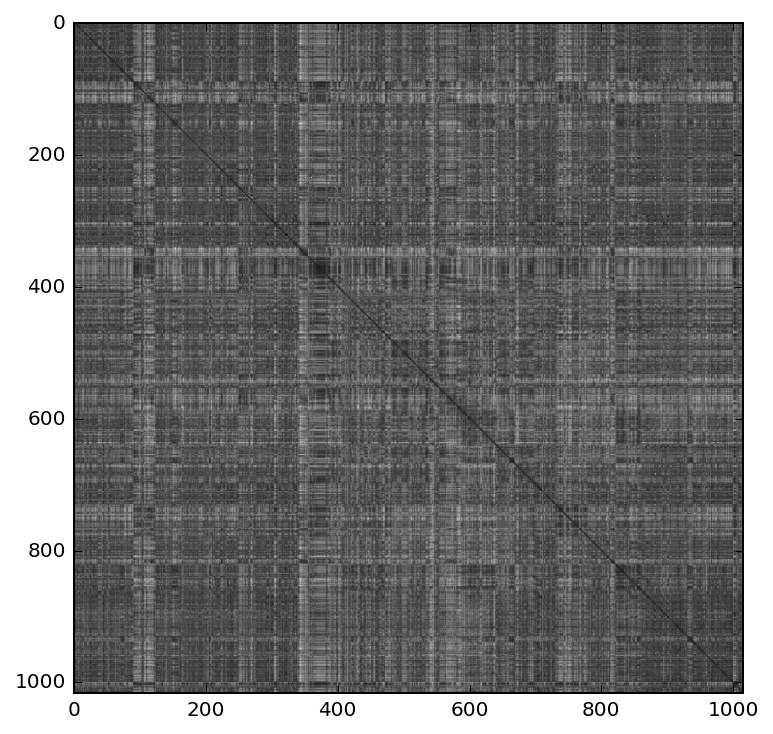

In [10]:
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

In [11]:
Km = int(N / 5)
Snorm_vals, Snorm_vecs = np.linalg.eig(Snorm)
indices = np.argsort(Snorm_vals)[::-1][:Km]
top_vecs = Snorm_vecs[indices].T
#display(top_vecs)

print(Km)
#eig_gmm = classify2(top_vecs, Km, 1)

#finalK = eig_gmm.n_components

203


In [12]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity='precomputed').fit(Snorm)

finalK = len(af.cluster_centers_indices_)
print(finalK)

21


In [13]:
final_hmms = []
final_nk = []
#top_classes = eig_gmm.predict(top_vecs)
top_classes = af.labels_
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(tmp1, tmp1_ls)
    #hmm1.fit(tmp1)
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


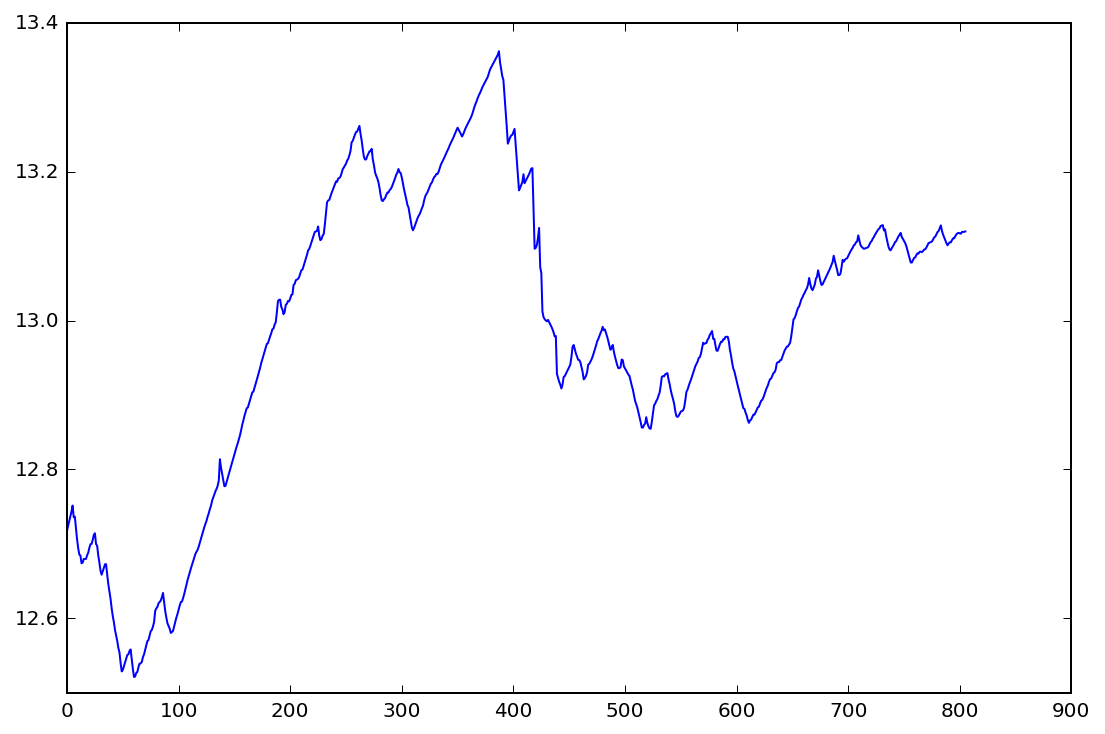

In [96]:
from hmmlearn.stats import _log_multivariate_normal_density_diag
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from hmmlearn.utils import log_mask_zero
from scipy.special import logsumexp

df_test = pd.read_csv("data_test.csv")
df_test.drop(df_test.columns[0], inplace=True, axis=1)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)

df2_test = df_test.drop([df_test.columns[0], df_test.columns[1]], axis=1)
df2_test = pd.DataFrame(scaler.transform(df2_test), columns=df_test.columns[2:])

df3_test = pd.DataFrame(bgmm.predict_proba(df2_test))
df3_test["time"] = df_test["time"]
df3_test["frame"] = df_test["frame"]
df3_test = df3_test.groupby(['time', 'frame']).agg('max')
df3_test.reset_index(inplace=True)

lattices = []

work_buffer = np.zeros(bgmm.n_components)

def my_forward_pass(hmm, fwdlattice, framelogprob, n_samples):
    n_samples_aa, n_components = framelogprob.shape    
    log_startprob = log_mask_zero(hmm.startprob_)
    log_transmat = log_mask_zero(hmm.transmat_)    
    if (n_samples == 1):
        for i in range(n_components):            
            fwdlattice[0, i] = log_startprob[i] + framelogprob[0, i]
    else:                    
        for j in range(n_components):
            for i in range(n_components):
                work_buffer[i] = fwdlattice[n_samples - 2, i] + log_transmat[i, j]            
            fwdlattice[n_samples - 1, j] = logsumexp(work_buffer) + framelogprob[0, j]
    return logsumexp(fwdlattice[n_samples - 1])

def calc_final_prob(samples):        
    i_a = []
    i_b = []
    
    for i in range(finalK):                                
        lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)        
        my_s = my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))
        act_s = my_s
        #act_s = final_hmms[i].score(samples)        
        #assert(np.allclose(my_s, act_s))
        
        i_a.append(act_s)
        i_b.append(float(final_nk[i]) / float(N))        
        
    return scipy.special.logsumexp(a=i_a, b=i_b)

TestPN = df3_test.drop(["time", "frame"], axis=1)
#TestPN = TestPN.head(1500)

for i in range(finalK):
    check_is_fitted(final_hmms[i], "startprob_")
    final_hmms[i]._check()
    lattices.append(np.zeros((len(TestPN), bgmm.n_components)))
                    
test_arr = []
scrs = []
scrs_raw = []
j = 1
for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)        
    scrs.append(prb / j)
    scrs_raw.append(prb)
    j += 1
    
plt.figure()
plt.plot(scrs[800:])
plt.show()    

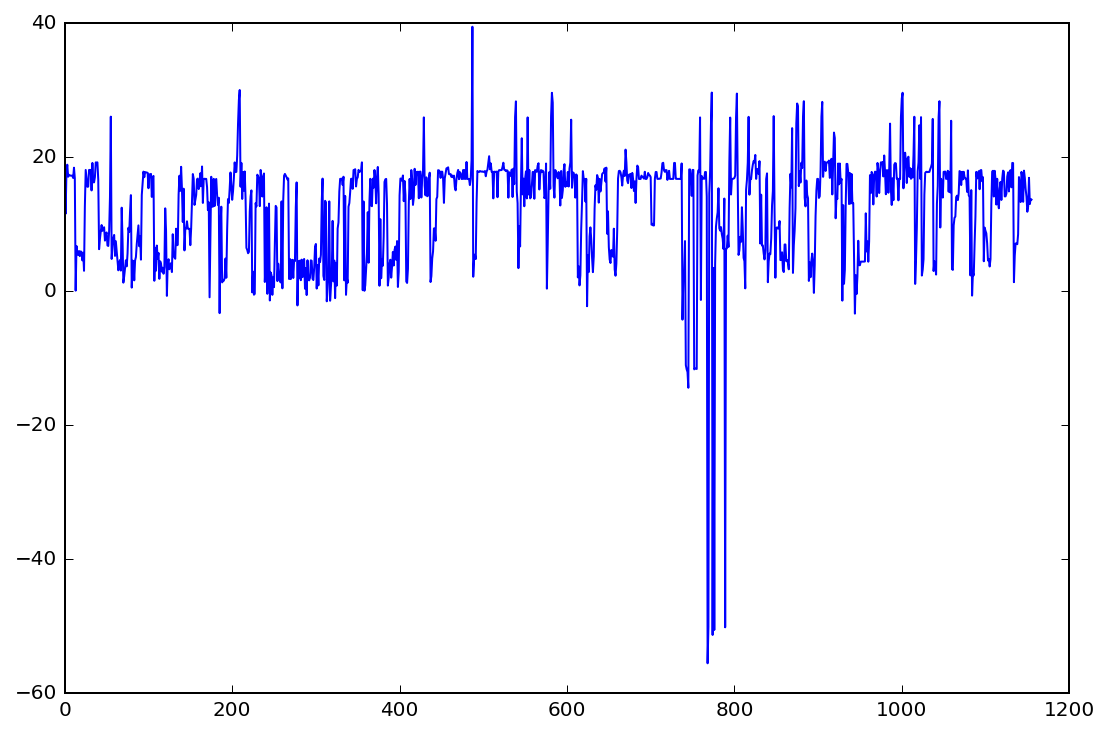

In [97]:
scrs2 = []

prev = 0

for i in range(len(TestPN)):    
    scrs2.append((scrs_raw[i] - prev) / (0 + 1))
    prev = scrs_raw[i]
    
plt.figure()
plt.plot(scrs2[int(seg_len * 1.5 * 10):])
plt.show()    

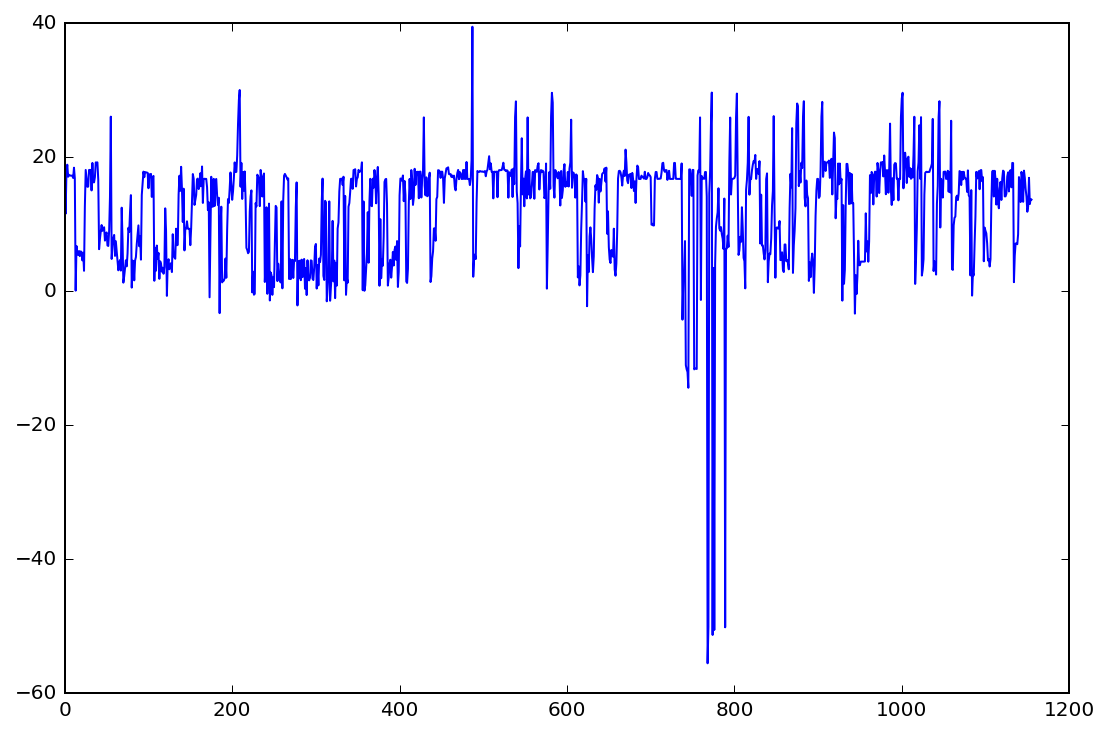

In [99]:
import traceback

Qt = 0
alpha = 0.2

first_frm = int(seg_len * 1.5 * 10)
first_frm_num = 0

qts = {}
qts_lst = []
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs[i] - scrs[i - 1])
    Qt = scrs2[i]
    qts[df3_test.iloc[i]["frame"]] = Qt
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3_test.iloc[i]["frame"]
            
plt.figure()
plt.plot(qts_lst[first_frm:])
plt.show()

#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
cap = cv2.VideoCapture('reception_long_test.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
cap = cv2.VideoCapture('reception_long_test.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < -40:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 0
        cv2.imshow('frame', frame)
        k = cv2.waitKey(delay) & 0xff
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()